# Programming Exercise 8: Anomaly Detection and Recommender Systems

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import optimize
from scipy.io import loadmat
from scipy.stats import multivariate_normal

In [2]:
import warnings
warnings.filterwarnings(action='ignore', category=RuntimeWarning)

## 1 Anomaly detection

In [3]:
data = loadmat("ex8data1.mat")
X = data["X"]
print(X.shape)
Xval, yval = data["Xval"], data["yval"].ravel()
print(Xval.shape, yval.shape)

(307, 2)
(307, 2) (307,)


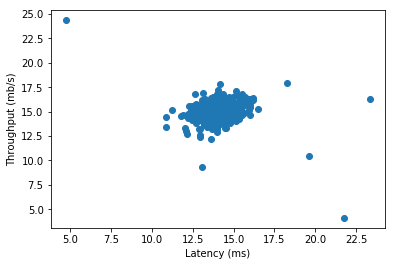

In [4]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.xlabel("Latency (ms)")
plt.ylabel("Throughput (mb/s)")
plt.show()

### 1.2 Estimating parameters for a Gaussian

In [5]:
def estimateGaussian(X):
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2

In [6]:
mu, sigma2 = estimateGaussian(X)
print(mu, sigma2)

[14.11222578 14.99771051] [1.83263141 1.70974533]


In [7]:
def visualizeFit(distribution, X):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.show()

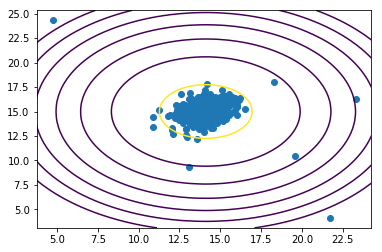

In [8]:
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
visualizeFit(distribution, X)

In [9]:
def selectThreshold(yval, pval):
    bestF1 = -np.inf
    step = (np.max(pval) - np.min(pval)) / 1000
    for epsilon in np.arange(np.min(pval),
                             np.max(pval) + step, step):
        predictions = (pval < epsilon).astype(int)
        tp = np.sum(np.multiply(predictions, yval))
        fp = np.sum(np.multiply(predictions, 1 - yval))
        fn = np.sum(np.multiply(1 - predictions, yval))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        F1 = 2 * precision * recall / (precision + recall)
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon
    return bestEpsilon, bestF1

In [10]:
pval = distribution.pdf(Xval)
bestEpsilon, bestF1 = selectThreshold(yval, pval)
print(bestEpsilon, bestF1)  # 8.99e-05 0.875000

8.990852779269493e-05 0.8750000000000001


In [11]:
def visualizeFit(distribution, X, outliers):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    X_plot = np.c_[xx.ravel(), yy.ravel()]
    y_plot = distribution.pdf(X_plot).reshape(xx.shape)

    plt.figure()
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(X[outliers, 0], X[outliers, 1], s=100)
    plt.contour(xx, yy, y_plot, levels=[1e-20, 1e-17, 1e-14, 1e-11, 1e-8, 1e-5, 1e-2])
    plt.show()

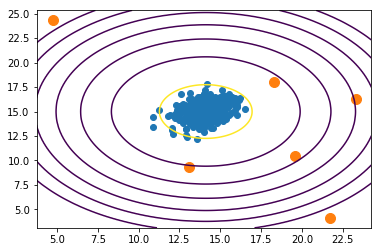

In [12]:
p = distribution.pdf(X)
outliers = np.where(p < bestEpsilon)[0]
visualizeFit(distribution, X, outliers)

### 1.4 High dimensional dataset

In [13]:
data = loadmat("ex8data2.mat")
X = data["X"]
print(X.shape)
Xval, yval = data["Xval"], data["yval"].ravel()
print(Xval.shape, yval.shape)

(1000, 11)
(100, 11) (100,)


In [14]:
mu, sigma2 = estimateGaussian(X)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
p = distribution.pdf(X)
pval = distribution.pdf(Xval)
bestEpsilon, bestF1 = selectThreshold(yval, pval)
print(bestEpsilon, bestF1)  # 1.38e-18 0.615385
print(sum(p < bestEpsilon))  # 117

1.3772288907613604e-18 0.6153846153846154
117


## 2 Recommender Systems

### 2.1 Movie ratings dataset

In [15]:
# The matrix Y (a num movies * num users matrix) stores the ratings y(i, j)
# (from 1 to 5). The matrix R is an binary-valued indicator matrix, where
# R(i, j) = 1 if user j gave a rating to movie i, and R(i, j) = 0 otherwise.
data = loadmat("ex8_movies.mat")
Y, R = data["Y"], data["R"]
print(Y.shape, R.shape)

(1682, 943) (1682, 943)


In [16]:
# The i-th row of X corresponds to the feature vector for the i-th movie,
# and the j-th row of Theta corresponds to one parameter vector for the j-th user.
data = loadmat("ex8_movieParams.mat")
X, Theta = data["X"], data["Theta"]
print(X.shape, Theta.shape)

(1682, 10) (943, 10)


In [17]:
print(np.mean(Y[0, R[0] == 1]))  # 3.878319

3.8783185840707963


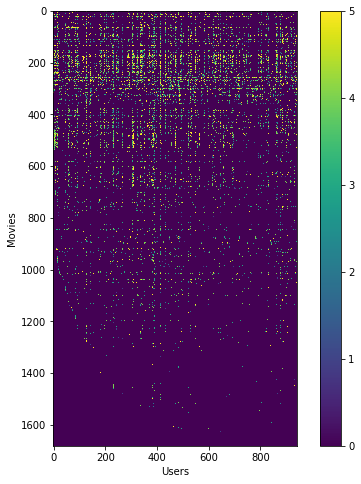

In [18]:
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.xlabel("Users")
plt.ylabel("Movies")
plt.colorbar()
plt.show()

### 2.2 Collaborative filtering learning algorithm

$$J(x^{(1)},...,x^{(n_m)},\theta^{(1)},...,\theta^{(n_u)}) =
    \frac{1}{2} \sum_{(i,j):r(i,j)=1}{((\theta^{(j)})^T x^{(i)} - y^{(i,j)})^2} + 
    (\frac{\lambda}{2} \sum_{j=1}^{n_u}{\sum_{k=1}^n{(\theta^{(j)}_k)^2}}) +
    (\frac{\lambda}{2} \sum_{i=1}^{n_m}{\sum_{k=1}^n{(x^{(i)}_k)^2}})$$

$$\frac{\partial J}{\partial x^{(i)}_k} =
    \sum_{j:r(i,j)=1}{((\theta^{(j)})^T x^{(i)} - y^{(i,j)}) \theta^{(j)}_k} +  \lambda x^{(i)}_k$$

$$\frac{\partial J}{\partial \theta^{(j)}_k} =
    \sum_{i:r(i,j)=1}{((\theta^{(j)})^T x^{(i)} - y^{(i,j)}) x^{(i)}_k} + \lambda \theta^{(j)}_k$$

In [19]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    J = np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R)) / 2
    J += np.sum(np.power(Theta, 2)) * lam / 2
    J += np.sum(np.power(X, 2)) * lam / 2

    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    for i in range(num_movies):
        idx = (R[i] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i] = np.dot(np.dot(Theta_temp, X[i]) - Y_temp, Theta_temp)
        X_grad[i] += lam * X[i]
    for i in range(num_users):
        idx = (R[:, i] == 1)
        X_temp = X[idx]
        Y_temp = Y[idx, i]
        Theta_grad[i] = np.dot(np.dot(X_temp, Theta[i]) - Y_temp, X_temp)
        Theta_grad[i] += lam * Theta[i]
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return J, grad

In [20]:
def cost(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    J = np.sum(np.multiply(np.power(np.dot(X, Theta.T) - Y, 2), R)) / 2
    J += np.sum(np.power(Theta, 2)) * lam / 2
    J += np.sum(np.power(X, 2)) * lam / 2
    return J


def gradient(params, Y, R, num_users, num_movies, num_features, lam):
    X = params[:num_movies * num_features]
    X = X.reshape((num_movies, num_features))
    Theta = params[num_movies * num_features:]
    Theta = Theta.reshape((num_users, num_features))

    X_grad = np.zeros(X.shape)
    Theta_grad = np.zeros(Theta.shape)
    for i in range(num_movies):
        idx = (R[i] == 1)
        Theta_temp = Theta[idx]
        Y_temp = Y[i, idx]
        X_grad[i] = np.dot(np.dot(Theta_temp, X[i]) - Y_temp, Theta_temp)
        X_grad[i] += lam * X[i]
    for i in range(num_users):
        idx = (R[:, i] == 1)
        X_temp = X[idx]
        Y_temp = Y[idx, i]
        Theta_grad[i] = np.dot(np.dot(X_temp, Theta[i]) - Y_temp, X_temp)
        Theta_grad[i] += lam * Theta[i]
    grad = np.hstack((X_grad.ravel(), Theta_grad.ravel()))
    return grad

In [21]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [22]:
params = np.hstack((X.ravel(), Theta.ravel()))
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 0)
print(J)  # 22.22

22.224603725685675


In [23]:
num_grad = np.zeros(len(grad))
e = 1e-4
for i in range(len(grad)):
    params1 = params.copy()
    params1[i] += e
    cost1 = cost(params1, Y, R, num_users, num_movies, num_features, 0)
    params2 = params.copy()
    params2[i] -= e
    cost2 = cost(params2, Y, R, num_users, num_movies, num_features, 0)
    num_grad[i] = (cost1 - cost2) / (2 * e)
print(grad[:5])
print(num_grad[:5])
assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]
[-2.52899165  7.57570308 -1.89979026 -0.56819597  3.35265031]


In [24]:
params = np.hstack((X.ravel(), Theta.ravel()))
J, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, 1.5)
print(J)  # 31.34

31.34405624427422


In [25]:
num_grad = np.zeros(len(grad))
e = 1e-4
for i in range(len(grad)):
    params1 = params.copy()
    params1[i] += e
    cost1 = cost(params1, Y, R, num_users, num_movies, num_features, 1.5)
    params2 = params.copy()
    params2[i] -= e
    cost2 = cost(params2, Y, R, num_users, num_movies, num_features, 1.5)
    num_grad[i] = (cost1 - cost2) / (2 * e)
print(grad[:5])
print(num_grad[:5])
assert np.linalg.norm(grad - num_grad) / np.linalg.norm(grad + num_grad) < 1e-9

[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]
[-0.95596339  6.97535514 -0.10861109  0.60308088  2.77421145]


### 2.3 Learning movie recommendations

In [26]:
movieList = {}
input_file = open("movie_ids.txt", encoding="latin-1")
for line in input_file.readlines():
    movie_info = line.strip().split(" ")
    movieList[int(movie_info[0]) - 1] = " ".join(movie_info[1:])
input_file.close()

In [27]:
ratings = np.zeros(1682)

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print("Rated {0} for {1}".format(ratings[0], movieList[0]))
print("Rated {0} for {1}".format(ratings[6], movieList[6]))
print("Rated {0} for {1}".format(ratings[11], movieList[11]))
print("Rated {0} for {1}".format(ratings[53], movieList[53]))
print("Rated {0} for {1}".format(ratings[63], movieList[63]))
print("Rated {0} for {1}".format(ratings[65], movieList[65]))
print("Rated {0} for {1}".format(ratings[68], movieList[68]))
print("Rated {0} for {1}".format(ratings[97], movieList[97]))
print("Rated {0} for {1}".format(ratings[182], movieList[182]))
print("Rated {0} for {1}".format(ratings[225], movieList[225]))
print("Rated {0} for {1}".format(ratings[354], movieList[354]))

Rated 4.0 for Toy Story (1995)
Rated 3.0 for Twelve Monkeys (1995)
Rated 5.0 for Usual Suspects, The (1995)
Rated 4.0 for Outbreak (1995)
Rated 5.0 for Shawshank Redemption, The (1994)
Rated 3.0 for While You Were Sleeping (1995)
Rated 5.0 for Forrest Gump (1994)
Rated 2.0 for Silence of the Lambs, The (1991)
Rated 4.0 for Alien (1979)
Rated 5.0 for Die Hard 2 (1990)
Rated 5.0 for Sphere (1998)


In [28]:
# The matrix Y (a num movies * num users matrix) stores the ratings y(i, j)
# (from 1 to 5). The matrix R is an binary-valued indicator matrix, where
# R(i, j) = 1 if user j gave a rating to movie i, and R(i, j) = 0 otherwise.
data = loadmat("ex8_movies.mat")
Y, R = data["Y"], data["R"]
print(Y.shape, R.shape)
Y = np.hstack((ratings[:, np.newaxis], Y))
R = np.hstack((((ratings != 0).astype(int))[:, np.newaxis], R))
print(Y.shape, R.shape)

(1682, 943) (1682, 943)
(1682, 944) (1682, 944)


In [29]:
def normalizeRatings(Y, R):
    Ymean = np.zeros(Y.shape[0])
    Ynorm = np.zeros(Y.shape)
    for i in range(Y.shape[0]):
        idx = (R[i] == 1)
        Ymean[i] = np.mean(Y[i, idx])
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
    return Ymean, Ynorm

In [30]:
num_users = Y.shape[1]
num_movies = Y.shape[0]
num_features = 10
rng = np.random.RandomState(0)
X = rng.randn(num_movies, num_features)
Theta = rng.randn(num_users, num_features)
params = np.hstack((X.ravel(), Theta.ravel()))
lam = 10
Ymean, Ynorm = normalizeRatings(Y, R)
res = optimize.minimize(fun=cost, x0=params,
                        args=(Ynorm, R, num_users, num_movies, num_features, lam),
                        method='CG', jac=gradient, options={"maxiter": 100})

In [31]:
X = res.x[:num_movies * num_features]
X = X.reshape((num_movies, num_features))
Theta = res.x[num_movies * num_features:]
Theta = Theta.reshape((num_users, num_features))

In [32]:
p = np.dot(X, Theta.T)
my_predictions = p[:, 0] + Ymean

In [33]:
for idx in np.argsort(my_predictions)[::-1][:10]:
    print(my_predictions[idx], movieList[idx])

5.000001235289081 Aiqing wansui (1994)
5.000000491918475 Star Kid (1997)
5.00000015553062 Prefontaine (1997)
4.999999945311844 Someone Else's America (1995)
4.999999920716767 Saint of Fort Washington, The (1993)
4.999999821845777 Entertaining Angels: The Dorothy Day Story (1996)
4.999999815543281 They Made Me a Criminal (1939)
4.999999800894499 Marlene Dietrich: Shadow and Light (1996)
4.9999969926087875 Great Day in Harlem, A (1994)
4.999993775139446 Santa with Muscles (1996)
